In [1]:
#### import global modules
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from yaml import safe_load
import google.oauth2.credentials
from google.cloud import bigquery
import gc

# Set global vars
pth_project = Path(os.getcwd().split('notebooks')[0])
pth_data = pth_project / 'data'
pth_queries = pth_project / 'core' / 'queries'
pth_creds = pth_project / 'conf' / 'local' / 'project_config.yaml'
sys.path.insert(0, str(pth_project))
d_project_config = safe_load(pth_creds.open())
# d_params = safe_load((pth_project / 'core' / 'parameters' / 'common.yaml').open())['data_extract']

# import local modules
from core.utils.gcp import connect_bq_services
# from core.etl.extract import extract_bq_data, extract_pr_codes, format_conv_df, filter_convs

# Connect to google services
bq_client = connect_bq_services(d_project_config['gcp-project-name'])
pd.options.display.max_rows = 100

In [2]:
def extract_bq_data(bq_client, sql=None, pth_query=None):
    if sql is not None:
        df = bq_client.query(sql).to_dataframe()
    elif pth_query is not None:
        sql = pth_query.read_text()
        df = bq_client.query(sql).to_dataframe()
    else:
        raise ValueError('`sql` or `pth_query` should be set')  
    return df

In [3]:
Query='''


DECLARE
  start_dt_snpsht DATE DEFAULT '2023-01-01';
DECLARE
  end_dt_snpsht DATE DEFAULT '2023-03-31';
--DECLARE
  --churn_dt_snpsht_start DATE DEFAULT '2023-03-01';
--DECLARE
  --churn_dt_snpsht_end DATE DEFAULT '2023-03-31';  




WITH Customer_Base as (select * from `divgpras-pr-579355.SHS.SHS_churn_model_base_score_data_jan23_mar23`)

, ADC_BP as ( 
select *,(Best_Practices_1+Best_Practices_2+Best_Practices_3+Best_Practices_4+Best_Practices_5+Best_Practices_6) as Best_Practice_All
from 

(
  -- #1 from_item
  SELECT 
    customer_id,
    best_practices_id,
     case when best_practices_ind=True then 1 else 0 end as Best_practices_flag,

  FROM `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_best_practice`
  where DATE(dt_last_calculate_utc) <= end_dt_snpsht
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_id,best_practices_id ORDER BY last_updt_ts DESC) = 1
)
PIVOT
(
  -- #2 aggregate
  sum(Best_practices_flag) AS Best_Practices
  -- #3 pivot_column
  FOR best_practices_id in (1,2,3,4,5,6)
)

)


,ADC_arming AS (

With date_sql as (
select  count(distinct date(date)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)<= end_dt_snpsht and date(date)>= start_dt_snpsht

)

select 
    id_cust as customer_id
    ,sum(count_arm_commands) as sum_arm_commands
    ,sum(count_disarm_commands) as sum_disarm_commands
    ,count (distinct date(date)) as number_days_arming_disarming
    , (select count_of_dates from date_sql ) as count_of_dates_arming
    , round(count (distinct date(date))*100/(select max(count_of_dates) from date_sql),0) as arming_consistency
    , round(sum(count_arm_commands)/(count (distinct date(date))),0) as Avg_arm_per_day
    ,round(sum(count_disarm_commands)/(count (distinct date(date))),0) as Avg_disarm_per_day
from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)<= end_dt_snpsht and date(date)>= start_dt_snpsht
group by customer_id
order by number_days_arming_disarming desc

)


, ADC_login as (

with date_sql as (
select  count(distinct date(login_dt_utc)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)<= end_dt_snpsht and date(login_dt_utc)>= start_dt_snpsht

)

select customer_id,sum(login_count) as sum_login_count,count (distinct date(login_dt_utc)) as number_of_login_days, (select count_of_dates from date_sql ) as count_of_dates_login, round(count (distinct date(login_dt_utc))*100/(select max(count_of_dates) from date_sql),0) as login_consistency, round(sum(login_count)/(count (distinct date(login_dt_utc))),0) as Avg_login_per_day
from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)<= end_dt_snpsht and date(login_dt_utc)>= start_dt_snpsht
group by customer_id
order by login_consistency desc



)


, cte_product_mix AS (
  
SELECT distinct cast (ffh_prod.bacct_bus_bacct_num as STRING) AS ban,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd IN ('SING', 'HSIC', 'TTV', 'SMHM', 'STV', 'DIIC','C') THEN ffh_prod.pi_prod_instnc_typ_cd ELSE NULL END) AS product_mix_all,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'HSIC' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS hsic_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'SING' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS sing_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'SMHM' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS shs_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'TTV'  THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS ttv_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'STV'  THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS stv_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'DIIC' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS diic_count   
         FROM `cio-datahub-enterprise-pr-183a.ent_cust_cust.bq_prod_instnc_snpsht` AS ffh_prod
   
   WHERE DATE(ffh_prod.prod_instnc_ts) = end_dt_snpsht
     AND ffh_prod.pi_prod_instnc_stat_cd = 'A' --Active Products
     AND ffh_prod.consldt_cust_typ_cd = 'R' --Regular (not Business)
     AND ffh_prod.pi_prod_instnc_typ_cd IN 
         (
           'DIIC', --Dialup
           'HSIC', --High Speed
           'SING', --Home Phone
           'SMHM', --Smart Home
           'STV',  --Satelite
           'TTV'   --TV
         )
GROUP BY ffh_prod.bacct_bus_bacct_num
--QUALIFY ROW_NUMBER() OVER (PARTITION BY ffh_prod.bacct_bus_bacct_num ORDER BY ffh_prod.prod_instnc_ts ) = 1
)



, ARPU_Calculation as(

with ARPU_full as (
SELECT
  distinct cast (billg_acct_num as string) AS ban,
  EXTRACT(YEAR
  FROM
    bill.bill_dt)||'-'||LPAD(CAST(EXTRACT(MONTH
      FROM
        bill.bill_dt) AS STRING), 2, '0') AS bill_year_month,
  sum(bill.rid_unit_chrg_amt) as ARPU_SMHM,
  sum(tot_inv_amt) as ARPU_FFH
  FROM
  `cio-datahub-enterprise-pr-183a.ent_cust_bill.bq_wln_inv_sum_view` bill
WHERE
  DATE(bill.bill_dt)>=  start_dt_snpsht
  and DATE(bill.bill_dt)<= end_dt_snpsht
  group by ban,bill_year_month
)

select ban, round(avg(ARPU_SMHM),0) as Avg_SMHM_ARPU,round(avg(ARPU_FFH),0) as Avg_FFH_ARPU 
from ARPU_full group by ban

)




select cb.*,bp.*,arm.* ,lg.*,prod_mix.*,ARPU.*
from Customer_Base cb
left join ADC_BP bp
on cb.customer_id=bp.customer_id
left join ADC_arming arm
on cb.customer_id=arm.customer_id
left join ADC_login lg
on cb.customer_id=lg.customer_id
left join cte_product_mix as prod_mix
on cb.BAN=prod_mix.ban
left join ARPU_Calculation as ARPU
on cb.BAN=ARPU.ban

'''

In [4]:
DF=extract_bq_data(bq_client, sql=Query)

In [5]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598803 entries, 0 to 598802
Data columns (total 52 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Telus_ID                      598803 non-null  object 
 1   BAN                           598803 non-null  object 
 2   contract_start_date           421171 non-null  object 
 3   contract_end_date             598803 non-null  object 
 4   Intial_activation_date        598803 non-null  object 
 5   contract_end_status           598803 non-null  object 
 6   Contract_start_months         421171 non-null  Int64  
 7   dealer_customer_id            461601 non-null  object 
 8   customer_id                   461601 non-null  Int64  
 9   primary_login_id              461601 non-null  Int64  
 10  dealer_name                   598803 non-null  object 
 11  join_date                     461601 non-null  object 
 12  account_type_name             461601 non-nul

In [14]:
DF.head()

,Telus_ID,BAN,contract_start_date,contract_end_date,Intial_activation_date,contract_end_status,Contract_start_months,dealer_customer_id,customer_id,primary_login_id,...,product_mix_all,hsic_count,sing_count,shs_count,ttv_count,stv_count,diic_count,ban_2,Avg_SMHM_ARPU,Avg_FFH_ARPU
0,98324694,603568819,2011-03-01,2014-03-01,2018-07-20,contract_expired,144,None,<NA>,<NA>,...,1,0,0,1,0,0,0,603568819,27.000000000,30.000000000
1,1640915,604839065,2021-09-08,2024-09-08,2021-09-08,contract_expiring_after_90_days,18,None,<NA>,<NA>,...,2,1,0,1,0,0,0,604839065,30.000000000,86.000000000
2,105061063,605529234,2022-01-01,2024-01-01,2022-11-17,contract_expiring_after_90_days,14,None,<NA>,<NA>,...,1,0,0,1,0,0,0,605529234,40.000000000,32.000000000
3,10094850,230744466,2022-05-27,2025-05-27,2022-05-27,contract_expiring_after_90_days,10,None,<NA>,<NA>,...,5,1,1,1,1,0,2,230744466,39.000000000,181.000000000
4,104963217,605483573,2021-04-24,2023-04-24,2022-10-31,contract_expiring_within_90_days,23,None,<NA>,<NA>,...,1,0,0,1,0,0,0,605483573,20.000000000,23.000000000


In [15]:
# DF['SMHM_Churn'].fillna(0,inplace=True)

In [16]:
# DF['churn_date'].fillna(0,inplace=True)

In [17]:
# DF['SMHM_Churn'].value_counts()

In [18]:
# DF['churn_date'].value_counts()

In [19]:
# DF['churn_date'].min()

In [20]:
# DF['SMHM_Churn'].value_counts(normalize=True)*100

In [21]:
DF['shs_count'].value_counts()

1     594446
2       4088
3        158
4         17
6          9
5          9
25         8
18         7
8          6
9          6
21         5
10         4
20         4
13         4
7          4
17         4
11         3
19         3
22         3
14         3
28         2
12         2
24         2
16         2
26         1
15         1
30         1
35         1
Name: shs_count, dtype: Int64

In [22]:
def login_consistency_cat(row):
    if row['login_consistency']>30:
        return 'Heavy_User'
    elif row['login_consistency']>0 and row['login_consistency']<=30:
        return 'Low_User'
    elif row['Interactivity_flag']==1:
        return 'No_User'
    elif row['Interactivity_flag']==0:
        return 'No_ADC_account'
    else:
        return 'None_of_the_above'

In [23]:
def arming_consistency_cat(row):
    if row['arming_consistency']>30:
        return 'Heavy_User'
    elif row['arming_consistency']>0 and row['arming_consistency']<=30:
        return 'Low_User'
    elif row['Interactivity_flag']==1:
        return 'No_User'
    elif row['Interactivity_flag']==0:
        return 'No_ADC_account'
    else:
        return 'None_of_the_above'

In [24]:
DF['login_consistency_cat']=DF.apply(login_consistency_cat,axis=1)

In [25]:
DF['arming_consistency_cat']=DF.apply(arming_consistency_cat,axis=1)

In [26]:
DF['login_consistency_cat'].value_counts()

Heavy_User        238595
No_ADC_account    137202
Low_User          132165
No_User            90841
Name: login_consistency_cat, dtype: int64

In [27]:
DF['BAN'].value_counts()

603568819    1
603841726    1
605681850    1
605667437    1
601652633    1
            ..
236070304    1
604648315    1
605009557    1
603581997    1
605664071    1
Name: BAN, Length: 598803, dtype: int64

In [28]:
DF=DF.drop_duplicates()

In [29]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598803 entries, 0 to 598802
Data columns (total 54 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Telus_ID                      598803 non-null  object 
 1   BAN                           598803 non-null  object 
 2   contract_start_date           421171 non-null  object 
 3   contract_end_date             598803 non-null  object 
 4   Intial_activation_date        598803 non-null  object 
 5   contract_end_status           598803 non-null  object 
 6   Contract_start_months         421171 non-null  Int64  
 7   dealer_customer_id            461601 non-null  object 
 8   customer_id                   461601 non-null  Int64  
 9   primary_login_id              461601 non-null  Int64  
 10  dealer_name                   598803 non-null  object 
 11  join_date                     461601 non-null  object 
 12  account_type_name             461601 non-nul

In [30]:
# BAN_list=DF['BAN'].value_counts().rename_axis('BAN').reset_index(name='unique_counts')

In [31]:
# BAN_list_2=BAN_list[BAN_list.unique_counts>1]

In [32]:
# BAN_list_2

In [33]:
# DF[DF['BAN']==604371757]
# .to_csv('Data_testing.csv',index=False)

In [34]:
config= bigquery.job.LoadJobConfig()

# config._properties['timePartitioning'] = {'field': 'Month_Year'}
config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

Table_BQ = 'SHS.SHS_churn_model_score_data_jan23_mar2023'

bq_table_instance= bq_client.load_table_from_dataframe(DF, Table_BQ,job_config=config)

In [35]:
Query_score_data= '''

select * from `divgpras-pr-579355.SHS.SHS_churn_model_score_data_jan23_mar2023`

'''

In [36]:
DF=extract_bq_data(bq_client, sql=Query_score_data)

In [37]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599329 entries, 0 to 599328
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Telus_ID                      599329 non-null  object 
 1   BAN                           599329 non-null  object 
 2   contract_start_date           421300 non-null  object 
 3   contract_end_date             599329 non-null  object 
 4   Intial_activation_date        599329 non-null  object 
 5   contract_end_status           599329 non-null  object 
 6   Contract_start_months         421300 non-null  Int64  
 7   dealer_customer_id            461900 non-null  object 
 8   customer_id                   461900 non-null  Int64  
 9   primary_login_id              461900 non-null  Int64  
 10  dealer_name                   599329 non-null  object 
 11  join_date                     461900 non-null  object 
 12  account_type_name             461900 non-nul

In [38]:
ID_cols=['customer_id','dealer_customer_id','BAN']
ignore_cols=['primary_login_id','dealer_name','join_date','account_type_name','customer_type_name','cust_bus_cust_id'
             ,'contract_start_date','contract_end_date','customer_id_1','customer_id_2','customer_id_3','ban_1','ban_2'
             ,'BAN_3','sum_arm_commands','sum_disarm_commands','number_days_arming_disarming','count_of_dates_arming'
             ,'sum_login_count','number_of_login_days','count_of_dates_login','shs_count','Telus_Cust_ID','Best_Practice_All','Intial_activation_date','Telus_ID','arming_consistency','Province_code']

Target_col=['SMHM_Churn']

In [39]:
DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])
DF['Avg_FFH_ARPU']=pd.to_numeric(DF['Avg_FFH_ARPU'])

In [40]:
num_cols=DF.select_dtypes(include=np.number).columns.tolist()
cat_cols=DF.select_dtypes(exclude=np.number).columns.tolist()

num_cols_features=list(set(num_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
cat_cols_features=list(set(cat_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
feature_cols=cat_cols_features+num_cols_features

In [41]:
DF[feature_cols].isnull().sum() * 100 / len(DF[feature_cols])

contract_end_status        0.000000
Package                    0.000000
arming_consistency_cat     0.000000
login_consistency_cat      0.000000
Best_Practices_5          24.560634
diic_count                 0.000000
login_consistency         38.117628
stv_count                  0.000000
ttv_count                  0.000000
Contract_start_months     29.704720
Best_Practices_2          24.560634
Interactivity_flag         0.000000
Avg_arm_per_day           63.381215
sing_count                 0.000000
Best_Practices_1          24.560634
Avg_login_per_day         38.117628
Tenure_months             22.930477
Avg_SMHM_ARPU              9.708190
Best_Practices_6          24.560634
Best_Practices_4          24.560634
Avg_FFH_ARPU               9.663974
ADT_migrated_customer      0.000000
hsic_count                 0.000000
product_mix_all            0.000000
Avg_disarm_per_day        63.381215
Best_Practices_3          24.560634
dtype: float64

In [42]:
def impute_missing_values(dataset=DF):
    
    for cols in dataset.columns:
        if dataset[cols].dtype == np.dtype('O'):
            # df.loc[np.isnan(df["Age"]), 'Age'] = rand1
            #dataset.loc[dataset[cols].isnull(), cols]="Missing_category"
            dataset[cols]=dataset[cols].fillna("Missing_category",inplace=False)
        else:
            dataset[cols]=dataset[cols].fillna(0,inplace=False)
            #dataset.loc[dataset[cols].isnull(), cols]=0
    return dataset

 
DF[feature_cols]=impute_missing_values(dataset=DF[feature_cols])

/tmp/ipykernel_3887/1067958573.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[cols]=dataset[cols].fillna("Missing_category",inplace=False)
/tmp/ipykernel_3887/1067958573.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[cols]=dataset[cols].fillna(0,inplace=False)


In [43]:
# DF['SMHM_Churn'].value_counts()

In [44]:
from pickle import dump,load
import warnings
import json
import joblib
## reading Intial feature list 
with open('Intial_feature_columns.json') as json_file:
    intial_feature_cols = json.load(json_file)


## reading final feature list 
with open('Final_feature_columns.json') as json_file:
    final_feature_cols = json.load(json_file)

In [45]:
intial_feature_cols

['stv_count',
 'Best_Practices_1',
 'Avg_login_per_day',
 'product_mix_all',
 'Package',
 'Avg_FFH_ARPU',
 'ADT_migrated_customer',
 'diic_count',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Tenure_months',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'ttv_count',
 'Best_Practices_6',
 'Avg_arm_per_day',
 'contract_end_status',
 'Best_Practices_4',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_5',
 'Avg_SMHM_ARPU',
 'login_consistency_cat',
 'arming_consistency_cat']

In [46]:
X_test_df= pd.get_dummies(DF[intial_feature_cols],prefix_sep='__')


In [47]:
def add_missing_dummy_columns(d, cols_req_model):
    ''' 
    This function adds missing columns to the data so that the model doesn't fail.
    d is the Dataset. 
    cols_req_model is the list of columns required by the model.
    
    '''
    missing_cols = list(set(cols_req_model) - set(d.columns))
    print('Adding columns', missing_cols, 'to the data and populating them with 0.')
    for c in missing_cols:
        d[c] = 0


def remove_extra_columns(d,cols_req_model):
    
    ''' 
    This function drops extra columns from the data so that the model doesn't fail.
    d is the Dataset. 
    cols_req_model is the list of columns required by the model.
    
    '''
    extra_cols= list(set( d.columns ) - set( cols_req_model ))
    print('Dropping', extra_cols, 'columns from the data.')
    d = d.drop(extra_cols, axis=1)
    return d

In [48]:
add_missing_dummy_columns(X_test_df,final_feature_cols)


Adding columns [] to the data and populating them with 0.


In [49]:
X_test_df=remove_extra_columns(X_test_df,final_feature_cols)


Dropping [] columns from the data.


In [50]:
X_test_df=X_test_df.reindex(columns=final_feature_cols,fill_value=0)

In [51]:
model_filename='XGB_SMHM_SMHM_churn_model_20230417_073900.pkl'
modle_pickle=joblib.load(model_filename)


In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer

def Capture_Rate_1stSD(ground_truth, prediction):
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    #print("data shape:", ground_truth.shape)

    prediction_df = pd.DataFrame(prediction, columns=["prob_of_predict_1"])
    # print(prediction_df.head())
    y_df = pd.DataFrame(ground_truth, columns=['target'])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))
    # Calculate lift on validation data
    v1 = prediction_with_label_df[['target', 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))
    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')['target'].transform(np.sum)
    vl2 = vl1.drop(['target', 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(
    vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    #vl2['Capture Rate_defintion'] = vl2['Freq']/vl2.iloc[19, 'Cumm Sum']
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()

    # this is lift csv
    # vl2.to_csv("/lift_chart_{0}.csv".format(today))
    # vl2.to_csv(
    # f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    # print(f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    #print("Training process completed success")
    Magic_score= round(vl2.iloc[0, 6],2)
    print("Cumm Capture Rate on 1st SD is: ", Magic_score)
    #vl2[vl2['SD'] == 1, 'Lift'].iloc[0]
    return Magic_score



def lift_calc_pd(model, X_test, y_test,target_column): # , model_path
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    prediction = model.predict_proba(X_test)
    print("output shape", prediction.shape)
    print("y_test shape:", y_test.shape)
    #Total_Actual_positive_targets=sum(y_test[target_column])
    #print('Total_Actual_positive_targets:',Total_Actual_positive_targets)


    prediction_df = pd.DataFrame(
    prediction, columns=['prob_of_predict_0', 'prob_of_predict_1'])
    y_df = pd.DataFrame(y_test, columns=[target_column])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))


    # Calculate lift on validation data
    v1 = prediction_with_label_df[[target_column, 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))


    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')[target_column].transform(np.sum)
    vl2 = vl1.drop([target_column, 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()
    # vl2['Capture_Rate_Defintion']= vl2['Freq']*100/Total_Actual_positive_targets
    # vl2['Cummu_Capture_Rate_Defintion']= vl2['Capture_Rate_Defintion'].cumsum()
    return pd.DataFrame(vl2)

In [53]:
# Test_lift=lift_calc_pd(model=modle_pickle,X_test=X_test_df
# ,y_test=DF[Target_col[0]],target_column=Target_col[0])

In [54]:
# Target_col[0]

In [55]:
# DF[Target_col[0]].value_counts()

In [56]:
# Test_lift

In [57]:
# Test_lift.to_csv('SHS_Churn_model_lift.csv',index=False)

In [58]:
# ID_DF=DF[ID_cols+Target_col]
# X_data=pd.concat([ID_DF,X_test_df],axis=1)

In [59]:
# X_data.head()

In [60]:
# X_data.columns

In [61]:
# # print(X_data.Package__Smart_Camera.sum()*100/X_data.shape[0])
# print(X_data.Package__Smart_Automation_Plus.sum()*100/X_data.shape[0])
# print(X_data.Package__Monitored.sum()*100/X_data.shape[0])

In [62]:
# x_SC=X_data[X_data.Package__Smart_Camera==1]
# # y_sc=x_SC[Target_col]


# Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
# ,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
# Test_lift.to_csv('Smart_Camera_Lift.csv',index=False)

In [63]:
# x_SC=X_data[X_data.Package__Smart_Automation_Plus==1]
# # y_sc=x_SC[Target_col]


# Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
# ,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
# Test_lift.to_csv('Smart_Automation_Plus_Lift.csv',index=False)

In [64]:
# x_SC=X_data[X_data.Package__Monitored==1]
# # y_sc=x_SC[Target_col]


# Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
# ,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
# Test_lift.to_csv('Monitored_Lift.csv',index=False)

In [65]:
# import shap
# x_SC=X_data[X_data.Package__Monitored==1]
# # model_shap = XGB_final_model.best_estimator_
# explainer = shap.TreeExplainer(modle_pickle)
# shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
# #%%

# shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
# , feature_names=final_feature_cols,show=False,max_display=15)

In [66]:
# import shap
# x_SC=X_data[X_data.Package__Monitored==1]
# # model_shap = XGB_final_model.best_estimator_
# explainer = shap.Explainer(modle_pickle)
# shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
# # #%%

# shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
# , feature_names=final_feature_cols,show=False,max_display=15)

In [67]:
# shap.plots.waterfall(shap_values[0])

In [68]:
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0])

In [69]:
# np.round(shap_values[[idx]],2)

In [70]:
# shap_values[idx]

In [71]:
# shap_values

In [72]:
# x_SC[final_feature_cols].iloc[[idx]]

In [73]:
# X_data.columns

In [74]:
# x_SC=X_data[(X_data.Package__Monitored==1) & (X_data.SMHM_Churn==1)]


In [75]:
final_feature_cols

['stv_count',
 'Best_Practices_1',
 'Avg_login_per_day',
 'product_mix_all',
 'Avg_FFH_ARPU',
 'ADT_migrated_customer',
 'diic_count',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Tenure_months',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'ttv_count',
 'Best_Practices_6',
 'Avg_arm_per_day',
 'Best_Practices_4',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_5',
 'Avg_SMHM_ARPU',
 'Package__Monitored',
 'Package__Smart_Automation_Plus',
 'Package__Smart_Camera',
 'Package__Unknown_Package',
 'contract_end_status__contract_expired',
 'contract_end_status__contract_expiring_after_90_days',
 'contract_end_status__contract_expiring_within_90_days',
 'login_consistency_cat__Heavy_User',
 'login_consistency_cat__Low_User',
 'login_consistency_cat__No_ADC_account',
 'login_consistency_cat__No_User',
 'arming_consistency_cat__Heavy_User',
 'arming_consistency_cat__Low_User',
 'arming_consistency_cat__No_ADC_account',
 'arming_consistency_cat__No_User']

In [ ]:
# pd.DataFrame(np.round(shap_values[[idx]],2),columns=final_feature_cols)

In [ ]:
# pd.DataFrame(x_SC[final_feature_cols].iloc[[idx]])

In [ ]:
# np.round(shap_values[[idx]],2).sum()

In [255]:
# plots the waterfall for the 6th observation. As optional input give waterfall_plot the number of features, in order to draw them all. Since all observations have the same number of features, the index of the second argument does not need to be adjusted.

In [256]:
# shap_values.base

In [257]:
# import shap
# x_SC=X_data[(X_data.Package__Monitored==1) & (X_data.SMHM_Churn==1)]
# # model_shap = XGB_final_model.best_estimator_
# explainer = shap.Explainer(modle_pickle)
# shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
# # #%%

# shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
# , feature_names=final_feature_cols,show=False,max_display=15)

In [258]:
# idx=10

# shap.plots._bar.bar_legacy(shap_values[idx],feature_names=final_feature_cols,show=True)

In [259]:
# x_SC[final_feature_cols].iloc[[idx]]

In [260]:
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[idx],feature_names=final_feature_cols,max_display=10)

In [261]:
# shap.summary_plot(shap_values[0], x_SC[final_feature_cols], plot_type="bar")

In [262]:
# shap.summary_plot(shap_values[1], x_SC[final_feature_cols].iloc[[idx]], plot_type="bar")

In [263]:
# shap.plots.bar(shap_values[0])

In [264]:
# idx=20
# print(x_SC.iloc[[idx]])
# print(np.round(shap_values[[idx]],2))
# shap.summary_plot(shap_values[[idx]], features=x_SC[final_feature_cols].iloc[[idx]]
# , feature_names=final_feature_cols,show=True,max_display=15)

In [265]:
# DF.info()

In [266]:
# import shap
# # model_shap = XGB_final_model.best_estimator_
# explainer = shap.Explainer(modle_pickle)
# shap_values = explainer.shap_values(X_test_df,check_additivity=False)
# #%%

# shap.summary_plot(shap_values, features=X_test_df
# , feature_names=final_feature_cols,show=False,max_display=15)

In [76]:
column_order=list(X_test_df.columns.sort_values())

In [77]:
column_order

['ADT_migrated_customer',
 'Avg_FFH_ARPU',
 'Avg_SMHM_ARPU',
 'Avg_arm_per_day',
 'Avg_disarm_per_day',
 'Avg_login_per_day',
 'Best_Practices_1',
 'Best_Practices_2',
 'Best_Practices_3',
 'Best_Practices_4',
 'Best_Practices_5',
 'Best_Practices_6',
 'Contract_start_months',
 'Interactivity_flag',
 'Package__Monitored',
 'Package__Smart_Automation_Plus',
 'Package__Smart_Camera',
 'Package__Unknown_Package',
 'Tenure_months',
 'arming_consistency_cat__Heavy_User',
 'arming_consistency_cat__Low_User',
 'arming_consistency_cat__No_ADC_account',
 'arming_consistency_cat__No_User',
 'contract_end_status__contract_expired',
 'contract_end_status__contract_expiring_after_90_days',
 'contract_end_status__contract_expiring_within_90_days',
 'diic_count',
 'hsic_count',
 'login_consistency_cat__Heavy_User',
 'login_consistency_cat__Low_User',
 'login_consistency_cat__No_ADC_account',
 'login_consistency_cat__No_User',
 'product_mix_all',
 'sing_count',
 'stv_count',
 'ttv_count']

In [78]:
# shap.plots.waterfall(shap_values[x])

In [79]:
result_churn_model=pd.DataFrame(modle_pickle.predict_proba(X_test_df) [:,1])

In [80]:
result_churn_model.mean()*100

0    0.472376
dtype: float32

In [93]:
result_churn_model.head()


,Churn_score
0,0.000006
1,0.000006
2,0.000001
3,0.000017
4,0.000006


In [94]:
result_churn_model.columns=['Churn_score']

In [83]:
# All_cols= ID_cols + X_test_df.columns.to_list()
# ID_DF=DF[['Telus_ID','BAN','customer_id','contract_start_date','contract_end_date','Intial_activation_date']]
ID_DF=DF

In [84]:
X_test_df=X_test_df.reindex(columns=column_order,fill_value=0)

In [96]:
Full_DF=pd.concat([ID_DF,result_churn_model],axis=1)

In [85]:
# Full_DF=pd.concat([ID_DF,X_test_df,result_churn_model],axis=1)

In [97]:
Full_DF.head()

,Telus_ID,BAN,contract_start_date,contract_end_date,Intial_activation_date,contract_end_status,Contract_start_months,dealer_customer_id,customer_id,primary_login_id,...,shs_count,ttv_count,stv_count,diic_count,ban_2,Avg_SMHM_ARPU,Avg_FFH_ARPU,login_consistency_cat,arming_consistency_cat,Churn_score
0,106042566,605821784,2021-09-02,2024-09-02,2023-03-17,contract_expiring_after_90_days,18,None,<NA>,<NA>,...,1,0,0,0,None,0.0,0.0,No_ADC_account,No_ADC_account,0.000006
1,106006232,605805102,2021-04-10,2023-04-10,2023-03-14,contract_expiring_within_90_days,23,None,<NA>,<NA>,...,1,0,0,0,None,0.0,0.0,No_ADC_account,No_ADC_account,0.000006
2,98318323,603566493,2004-03-01,2007-03-01,2018-07-20,contract_expired,228,None,<NA>,<NA>,...,1,0,0,0,603566493,32.0,36.0,No_ADC_account,No_ADC_account,0.000001
3,102992506,604780490,2021-09-07,2024-09-07,2021-09-03,contract_expiring_after_90_days,18,None,<NA>,<NA>,...,1,1,0,0,604780490,30.0,116.0,No_ADC_account,No_ADC_account,0.000017
4,106001085,605798611,2023-02-01,2026-02-01,2023-03-14,contract_expiring_after_90_days,1,None,<NA>,<NA>,...,1,0,0,0,None,0.0,0.0,No_ADC_account,No_ADC_account,0.000006


In [98]:
Full_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599329 entries, 0 to 599328
Data columns (total 54 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Telus_ID                      599329 non-null  object 
 1   BAN                           599329 non-null  object 
 2   contract_start_date           421300 non-null  object 
 3   contract_end_date             599329 non-null  object 
 4   Intial_activation_date        599329 non-null  object 
 5   contract_end_status           599329 non-null  object 
 6   Contract_start_months         599329 non-null  Int64  
 7   dealer_customer_id            461900 non-null  object 
 8   customer_id                   461900 non-null  Int64  
 9   primary_login_id              461900 non-null  Int64  
 10  dealer_name                   599329 non-null  object 
 11  join_date                     461900 non-null  object 
 12  account_type_name             461900 non-nul

In [91]:
Full_DF['ADT_migrated_customer'].head()

,ADT_migrated_customer,ADT_migrated_customer
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1


In [100]:
ADT_migrated_DF=Full_DF[Full_DF['ADT_migrated_customer']==1]

In [102]:
ADT_migrated_DF.to_csv('ADT_Migrated_customer.csv')

In [280]:
# Output_DF_1=Output_DF.merge(TEST_DF_FULL[ID_cols],on=ID_cols,how='left')

In [281]:
# Output_DF=pd.concat([ID_DF,result_churn_model],axis=1)

In [282]:
# Output_DF.head()

In [283]:
# Output_DF.columns=ID_cols+['Churn_score']

In [284]:
Full_DF['Churn_SD'] = pd.qcut(Full_DF['Churn_score'].rank(method='first',ascending=False), q=20, labels=False)+1


In [285]:
Full_DF_HRC=Full_DF[Full_DF['Churn_SD']<=2]

In [286]:
Full_DF_HRC['Churn_score'].mean()*100


4.0457382798194885

In [287]:
Full_DF_HRC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59933 entries, 12 to 228448
Data columns (total 44 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Telus_ID                                               59933 non-null  object 
 1   BAN                                                    59933 non-null  object 
 2   customer_id                                            58474 non-null  Int64  
 3   contract_start_date                                    59933 non-null  object 
 4   contract_end_date                                      59933 non-null  object 
 5   Intial_activation_date                                 59933 non-null  object 
 6   ADT_migrated_customer                                  59933 non-null  Int64  
 7   Avg_FFH_ARPU                                           59933 non-null  float64
 8   Avg_SMHM_ARPU                               

In [288]:
pd.DataFrame(Full_DF_HRC.groupby(['Package__Smart_Camera']).agg(
    
    Customer_count= ('customer_id','nunique'),
    # Churn_total_telus=('Churn_score',lambda x: x.sum()),
    Churn_rate_telus=('Churn_score',lambda x: x.mean()*100),
    # Churn_total=('Churn_flag',lambda x: x.sum()),
    # Churn_rate=('Churn_flag',lambda x: x.mean()*100)
).reset_index())

,Package__Smart_Camera,Customer_count,Churn_rate_telus
0,0,45320,4.302227
1,1,13154,3.133600


In [289]:
pd.DataFrame(Full_DF_HRC.groupby(['Package__Monitored']).agg(
    
    Customer_count= ('customer_id','nunique'),
    # Churn_total_telus=('Churn_score',lambda x: x.sum()),
    Churn_rate_telus=('Churn_score',lambda x: x.mean()*100),
    # Churn_total=('Churn_flag',lambda x: x.sum()),
    # Churn_rate=('Churn_flag',lambda x: x.mean()*100)
).reset_index())

,Package__Monitored,Customer_count,Churn_rate_telus
0,0,30922,3.274713
1,1,27552,4.951901


In [290]:
Full_DF_HRC['Churn_score'].mean()*100

4.0457382798194885

In [291]:
Full_DF_HRC['Churn_score'].max()

0.48420748

In [292]:
Full_DF['Churn_score'].mean()*100

0.44453381560742855

In [293]:
Full_DF_HRC=Full_DF_HRC.sort_values('Churn_score',ascending=False)

In [294]:
Full_DF_HRC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59933 entries, 214172 to 31824
Data columns (total 44 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Telus_ID                                               59933 non-null  object 
 1   BAN                                                    59933 non-null  object 
 2   customer_id                                            58474 non-null  Int64  
 3   contract_start_date                                    59933 non-null  object 
 4   contract_end_date                                      59933 non-null  object 
 5   Intial_activation_date                                 59933 non-null  object 
 6   ADT_migrated_customer                                  59933 non-null  Int64  
 7   Avg_FFH_ARPU                                           59933 non-null  float64
 8   Avg_SMHM_ARPU                            

In [295]:
Full_DF_HRC.to_csv('SHS_Model_score_Top_decile.csv',index=False)

In [ ]:
config= bigquery.job.LoadJobConfig()

# config._properties['timePartitioning'] = {'field': 'Month_Year'}
config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

Table_BQ = 'SHS.SHS_Model_score_top_decile'

bq_table_instance= bq_client.load_table_from_dataframe(Full_DF_HRC, Table_BQ,job_config=config)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


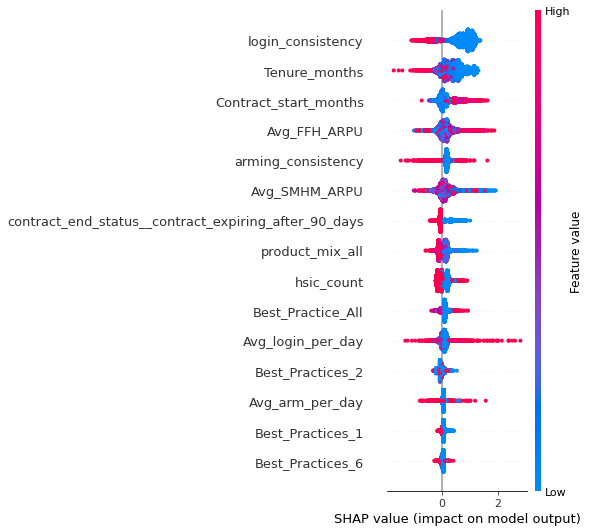

In [337]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer = shap.Explainer(modle_pickle)
shap_values_local = explainer.shap_values(Full_DF_HRC[final_feature_cols],check_additivity=False)
#%%

shap.summary_plot(shap_values_local, features=Full_DF_HRC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)


# shap.plots.bar(shap_values_local[0]) # For the first observation


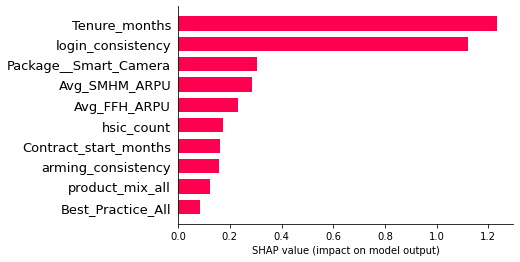

In [447]:
idx=50
shap.plots._bar.bar_legacy(shap_values_local[idx],feature_names=final_feature_cols,show=True,max_display=10)

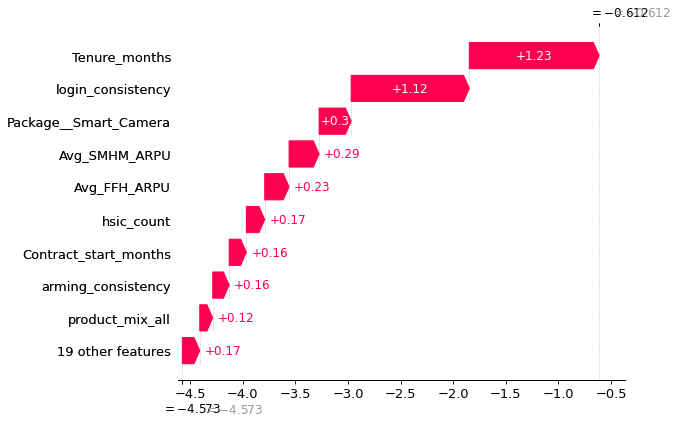

In [450]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_local[idx],feature_names=final_feature_cols,max_display=10)

In [451]:
Full_DF_HRC[ID_cols+['Churn_score','login_consistency','Tenure_months','Contract_start_months','Avg_FFH_ARPU','Avg_SMHM_ARPU','product_mix_all','Package__Smart_Camera','Package__Smart_Automation_Plus']].iloc[idx]

customer_id                        15236342
dealer_customer_id                105402816
BAN                               605634186
Churn_score                        0.351526
login_consistency                       1.0
Tenure_months                             0
Contract_start_months                     0
Avg_FFH_ARPU                            0.0
Avg_SMHM_ARPU                           0.0
product_mix_all                           2
Package__Smart_Camera                     1
Package__Smart_Automation_Plus            0
Name: 58570, dtype: object

In [406]:
Full_DF_HRC['Churn_score'].iloc[idx]

0.3515264

In [342]:
shap.force_plot(explainer.expected_value, shap_values_local[idx], features=Full_DF_HRC[final_feature_cols].iloc[[idx]], feature_names=final_feature_cols)

In [453]:
Full_DF_LRC=Full_DF[Full_DF['Churn_SD']==20]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


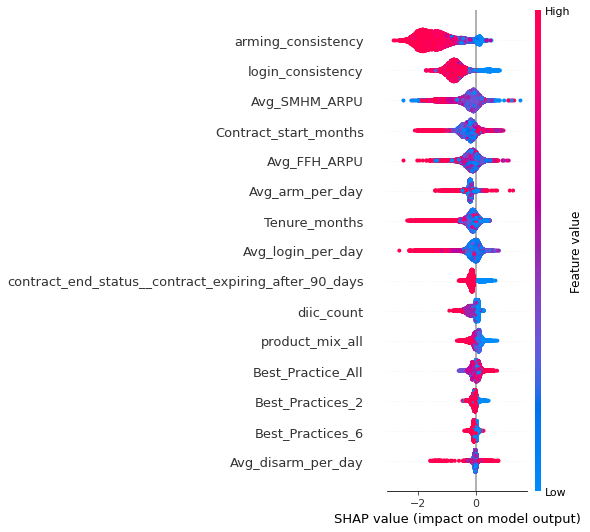

In [454]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer_LRC = shap.Explainer(modle_pickle)
shap_values_local_LRC = explainer.shap_values(Full_DF_LRC[final_feature_cols],check_additivity=False)
#%%

shap.summary_plot(shap_values_local_LRC, features=Full_DF_LRC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)

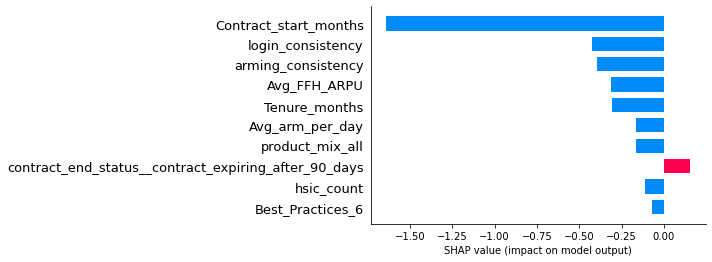

In [455]:
idx=50
shap.plots._bar.bar_legacy(shap_values_local_LRC[idx],feature_names=final_feature_cols,show=True,max_display=10)

In [343]:
# shap.initjs()

# shap.force_plot(explainer.expected_value[1], shap_values_local[1], Full_DF[final_feature_cols])

In [344]:

# shap.plots.bar(shap_values_local[0]) # For the first observation
# # shap.plots.waterfall(shap_values_local[1])

In [167]:
import shap
from shap import Explainer, Explanation
from shap import waterfall_plot
X_pred=Full_DF[final_feature_cols]
idx = 9
explainer = Explainer(modle_pickle)
sv = explainer(X_pred.iloc[[idx]])
# model_shap = XGB_final_model.best_estimator_
# explainer = shap.TreeExplainer(modle_pickle)
# shap_values_local = explainer.shap_values(Full_DF[final_feature_cols],check_additivity=False)
#%%

exp = Explanation(
    sv.values[:, :, 1],         # class to explain
    sv.base_values[:, 1],
    data=FX_pred.iloc[[idx]].values,   # corrected, pass the row of interest as df
    feature_names=final_feature_cols,
)
waterfall(exp[0])               # pretend you have only 1 data point which is 0th 

# shap.summary_plot(shap_values_local, features=Full_DF[final_feature_cols]
# , feature_names=final_feature_cols,show=False,max_display=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [161]:
Full_DF[final_feature_cols].loc[[0]]

KeyError: "None of [Int64Index([0], dtype='int64')] are in the [index]"

In [166]:
Full_DF.iloc[[0]]

,customer_id,dealer_customer_id,BAN,SMHM_Churn,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,...,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera,Churn_score,Churn_SD
9,14874964,103411504,604915974,0,0,0.0,0,0,0,2,...,0.0,2,1,0,0,0,1,0,0.144503,1


In [ ]:
exp = Explanation(sv[:,:,6], sv.base_values[:,6], X_train, feature_names=None)

In [145]:
shap_values[0]

array([-4.42003720e-02, -5.20775979e-03,  7.32300282e-02, -1.17910991e-03,
       -8.40417389e-03, -3.18821430e-01,  1.62857193e-02, -1.39016831e+00,
       -2.04607844e-01, -2.94067096e-02, -2.19816975e-02,  8.26461017e-02,
        7.04055943e-04, -8.92780442e-03,  3.89393717e-02, -1.91082302e-02,
        1.04699265e-02,  9.14853625e-03, -2.99767315e-01, -8.34878534e-03,
        2.93430507e-01, -1.50675774e-01, -5.26572056e-02,  5.14006197e-01,
       -3.90582643e-02,  1.53252622e-02,  3.55479687e-01, -4.02908213e-03],
      dtype=float32)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!